In [21]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
import copy

print(torch.__version__)


1.6.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Runnning on {device}')

base_dir = 'data/hymenoptera_data/'
num_classes = 2 # bees, ants
input_size = 256
mean_norm = [0.485, 0.456, 0.406]
std_norm = [0.229, 0.224, 0.225]



Runnning on cpu


In [4]:
transform = transforms.Compose([transforms.RandomResizedCrop(input_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_norm, std_norm)
                                ])


# create dataset
train_dataset = datasets.ImageFolder(base_dir+'train/', transform=transform)
test_dataset = datasets.ImageFolder(base_dir+'val/', transform= transform)

# create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1) # larger batch size for validation



In [56]:

def tensor_to_PIL(x):
    for c in range(3): #rgb
        x[c] *= std_norm[c]
        x[c] += mean_norm[c]
    
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(x)
    return img

def view_tensor(x):
    img = tensor_to_PIL(x)
    plt.imshow(img)

def view_sample(index):
    x,y = train_dataset[index]
    
    for c in range(3):
        x[c] *= std_norm[c]
        x[c] += mean_norm[c]
    
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(x)
    plt.imshow(img)
    label = "Ant" if y==0 else "Bee"
    plt.title(label)

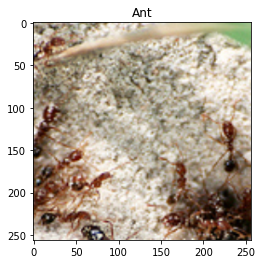

In [7]:
view_sample(1)

In [8]:
# Load in pretrained classifier model
model = torch.load('/Users/kulkarniad/Downloads/ant_bee_resnet101_val95.torch',map_location=torch.device('cpu'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
criterion = nn.CrossEntropyLoss()


In [82]:
def top_losses(model,dset,criterion,num_losses = 5):
    with torch.no_grad():
        losses = pd.DataFrame({'Label':[],'Pred':[],'Loss':[],'Tensor':[]})
        for (x,y) in tqdm(dset):

            x = x.unsqueeze(0)
            y = torch.tensor([y])

            x = x.to(device)
            y = y.to(device)
            model.to(device)

            output = model(x)
            loss = criterion(output,y)

            label = dset.classes[y]
            pred = dset.classes[torch.argmax(output,1)]

            losses = losses.append({'Label':label,'Pred':pred,'Loss':loss.item(),'Tensor':tensor_to_PIL(x[0])},ignore_index=True)
            losses = losses.sort_values(by=['Loss'],ascending=False).iloc[:num_losses]


        return losses
        

def view_top_losses(df):
    plt.figure(figsize=(20,5))
    num = len(df)
    for i in range(len(df)):
        plt.subplot(1,num,i+1)
        plt.imshow(df.iloc[i]['Tensor'])
        plt.title(f"Label:{df.iloc[i]['Label']},pred:{df.iloc[i]['Pred']},loss:{round(df.iloc[i]['Loss'],3)}")
        plt.tight_layout()


100%|██████████| 153/153 [00:59<00:00,  2.57it/s]


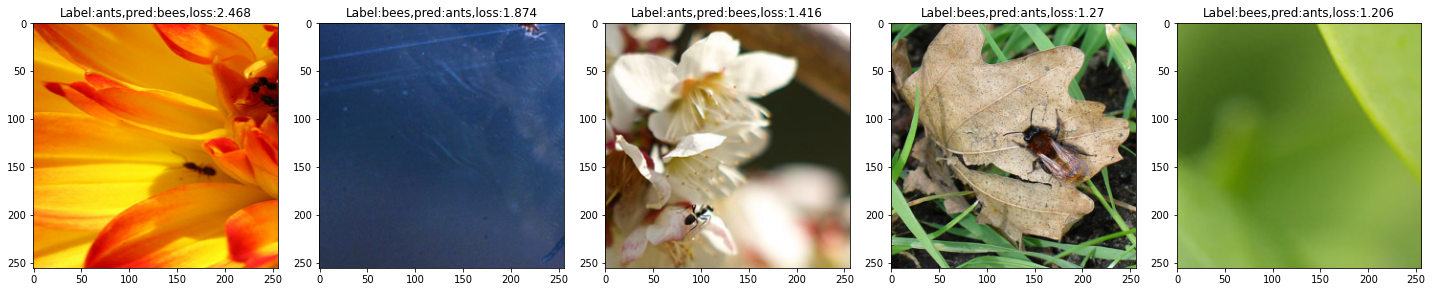

In [83]:
df = top_losses(model,test_dataset,criterion)
view_top_losses(df)